# Figures of hypothesis kernel analysis project
Non-computational figures can be found in the `misc_figures.ipynb` notebook. Code to run the analyses that result in the data visualized in this notebook is stored in the `src/analysis` directory of this repository.

In [5]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# For t-tests
from scipy.stats import ttest_ind, ttest_rel, ttest_1samp

# Plotting parameters
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = "DejaVu Sans"
matplotlib.rcParams['figure.facecolor'] = "white"

dpi = 300
ylabel_size = 14
xlabel_size = 14
tick_size = 12
txt_size = 12
legend_size = 12

In [6]:
# Some preprocessing utils + plotting parameters
map2leg = {
    'Darwin': 'Darwin\n(1886)',
    'Matsumoto2008': 'Matsumoto et al.\n(2008)',
    'Keltner2019': 'Keltner et al.\n(2019)',
    'Cordaro2018ref': 'Cordaro et al.\n(2018; ref.)',
    'Cordaro2018IPC': 'Cordaro et al.\n(2018; ICP)',
    'Ekman': 'Friesen &\nEkman (1978)',
    'JackSchyns': 'Jack et al.\n(2014)'
}

map_names = list(map2leg.values())
emo_names = ['anger', 'disgust', 'fear', 'happy', 'sadness', 'surprise']
au_names = np.loadtxt('../data/au_names_new.txt', dtype=str)

## Main figure 3: Prediction
Plot train set prediction performance per mapping (A) and split by culture (B).

In [7]:
# Load in theory-driven scores (scores.tsv) and cross-validated data-driven scores (scores_js.tsv)
df = pd.read_csv('../results/scores.tsv', sep='\t', index_col=0)
df_js = pd.read_csv('../results/scores_js.tsv', sep='\t', index_col=0)
df_js = df_js.query("model_ethnicity == 'all'").drop('model_ethnicity', axis=1)
df = pd.concat((df, df_js), axis=0)
df = df.replace(map2leg)

# Add average across emotions to df for plotting (rightmost panel)
df_av = df.groupby(['mapping', 'sub', 'sub_ethnicity']).mean().reset_index()
df = pd.concat([df, df_av.assign(emotion='average')], axis=0)

nc = pd.read_csv('../results/noise_ceiling.tsv', sep='\t', index_col=0)
nc_av = nc.groupby(['sub_ethnicity', 'sub_split', 'trial_split']).mean().reset_index().assign(emotion='average')
nc_ = pd.concat((nc, nc_av), axis=0)
nc_all = nc_.query("sub_split == 'train' & trial_split == 'train' & sub_ethnicity == 'all'")
nc_ethn = nc_.query("sub_split == 'train' & trial_split == 'train' & sub_ethnicity != 'all'")

NameError: name 'ylabel_size' is not defined

/home/lukass/miniconda3/envs/hka/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


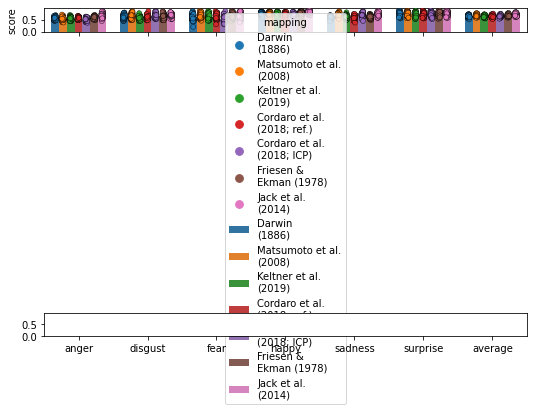

In [12]:
gs_kw = dict(width_ratios=[1.4, 1])
fig, axes = plt.subplots(figsize=(7.3, 4.87), nrows=2, ncols=2, constrained_layout=True, sharex=True, sharey=True, gridspec_kw=gs_kw)

ax = axes[0]
ax = sns.barplot(x='emotion', y='score', data=df, hue='mapping',
                 ax=ax, ci='sd', hue_order=map_names)

ax = sns.stripplot(x='emotion', y='score', hue='mapping',
                   edgecolor='black', linewidth=0.4, data=df, ax=ax,
                   dodge=True, jitter=True, hue_order=map_names)

ax.set_xlabel('')
ax.set_ylabel('AUROC', fontsize=ylabel_size)
#ax.yaxis.set_label_coords(-0.04, 0.55)

n_tk = df['mapping'].unique().size
for i, emo in enumerate(emo_names + ['average']):
    this_nc = nc_all.query("emotion == @emo")['noise_ceiling'].item()
    this_sd = nc_all.query("emotion == @emo")['sd'].item()
    ax.plot(np.linspace(i-0.4, i+0.4, num=n_tk), [this_nc] * n_tk, c='k', ls='--')
    ax.fill_between(
        np.linspace(i-0.4, i+0.4, num=n_tk),
        [this_nc - this_sd] * n_tk, [this_nc + this_sd] * n_tk,
        color='gray', alpha=0.3
    )
    ax.text(i - 0.1, this_nc + 0.075, f'{this_nc:.2f}', fontsize=txt_size)

# Some aesthetics
ax.set_facecolor('white')
ax.set_ylim(0.45, 1)
ax.axhline(0.5, c='k', ls='-')
ax.legend_.remove()
colors = {mapp: sns.color_palette()[i] for i, mapp in enumerate(map_names)}
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
legend = ax.legend(handles, labels, ncol=7, loc=(-0.045, 1.075), frameon=False, fontsize=5)

ax.tick_params(axis='y', labelsize=tick_size)
ax.tick_params(axis='x', labelsize=tick_size)

ax = axes[1]
df_av_map = df.groupby(['emotion', 'sub_ethnicity', 'sub']).mean().reset_index()
hue_order = ['WC', 'EA']
ax = sns.barplot(x='emotion', y='score', data=df_av_map, hue='sub_ethnicity', palette='Set2',
                 ax=ax, ci='sd', hue_order=hue_order, order=emo_names + ['average'])

ax = sns.stripplot(x='emotion', y='score', hue='sub_ethnicity', palette='Set2',
                   edgecolor='black', linewidth=0.4, data=df_av_map,
                   dodge=True, jitter=True, hue_order=hue_order, order=emo_names + ['average'])

ax.set_xlabel('')
ax.set_ylabel('AUROC', fontsize=ylabel_size)
#ax.yaxis.set_label_coords(-0.04, 0.55)

# Some aesthetics
ax.set_facecolor('white')
ax.set_ylim(0.45, 1)
ax.axhline(0.5, c='k', ls='-')

colors = {name: sns.color_palette('Set2')[i] for i, name in enumerate(['Western', 'East-Asian'])}
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
legend = plt.legend(handles, labels, loc=(0.01, 0.82), frameon=False, fontsize=legend_size)

ax.tick_params(axis='y', labelsize=tick_size)
ax.tick_params(axis='x', labelsize=tick_size)

for i, emo in enumerate(emo_names + ['average']):
    ea = df.query("emotion == @emo & sub_ethnicity == 'EA'")
    wc = df.query("emotion == @emo & sub_ethnicity == 'WC'")
    
    # Average across mappings
    wc = wc.groupby(['emotion', 'sub', 'sub_ethnicity']).mean().reset_index()
    ea = ea.groupby(['emotion', 'sub', 'sub_ethnicity']).mean().reset_index()
    
    wc_, ea_ = wc['score'].dropna().to_numpy(), ea['score'].dropna().to_numpy()
    cohens_d = (wc_.mean() - ea_.mean()) / np.sqrt((wc_.var() + ea_.var()) / 2)
    tval, pval = ttest_ind(wc_, ea_)
    print(f"Emotion = {emo}, t-value: {tval:.2f}, p-value: {pval:.5f}, d: {cohens_d:.2f}")    
    if pval < 0.05:
        ax.text(i, 0.95, '*', fontsize=txt_size)

for i, emo in enumerate(emo_names + ['average']):
    
    for ii, ethn in enumerate(['WC', 'EA']):
        this_nc = nc_ethn.query("sub_ethnicity == @ethn & emotion == @emo")['noise_ceiling'].item()
        this_sd = nc_ethn.query("sub_ethnicity == @ethn & emotion == @emo")['sd'].item()
        ax.plot(np.linspace(i-0.4 + ii * 0.4, i + ii * 0.4, num=n_tk), [this_nc] * n_tk, c='k', ls='--')

        ax.fill_between(
            np.linspace(i-0.4 + ii * 0.4, i + ii * 0.4, num=n_tk),
            this_nc - this_sd, this_nc + this_sd,
            color='gray', alpha=0.3
        )

ax.set_xlim(-0.5, 6.5)
sns.despine()
fig.set_constrained_layout_pads(h_pad=0.25)
plt.savefig('figure_3.pdf', dpi=300, facecolor='white', bbox_inches='tight')


## Supplementary figure S1
Show difference between cultures for each mapping separately.

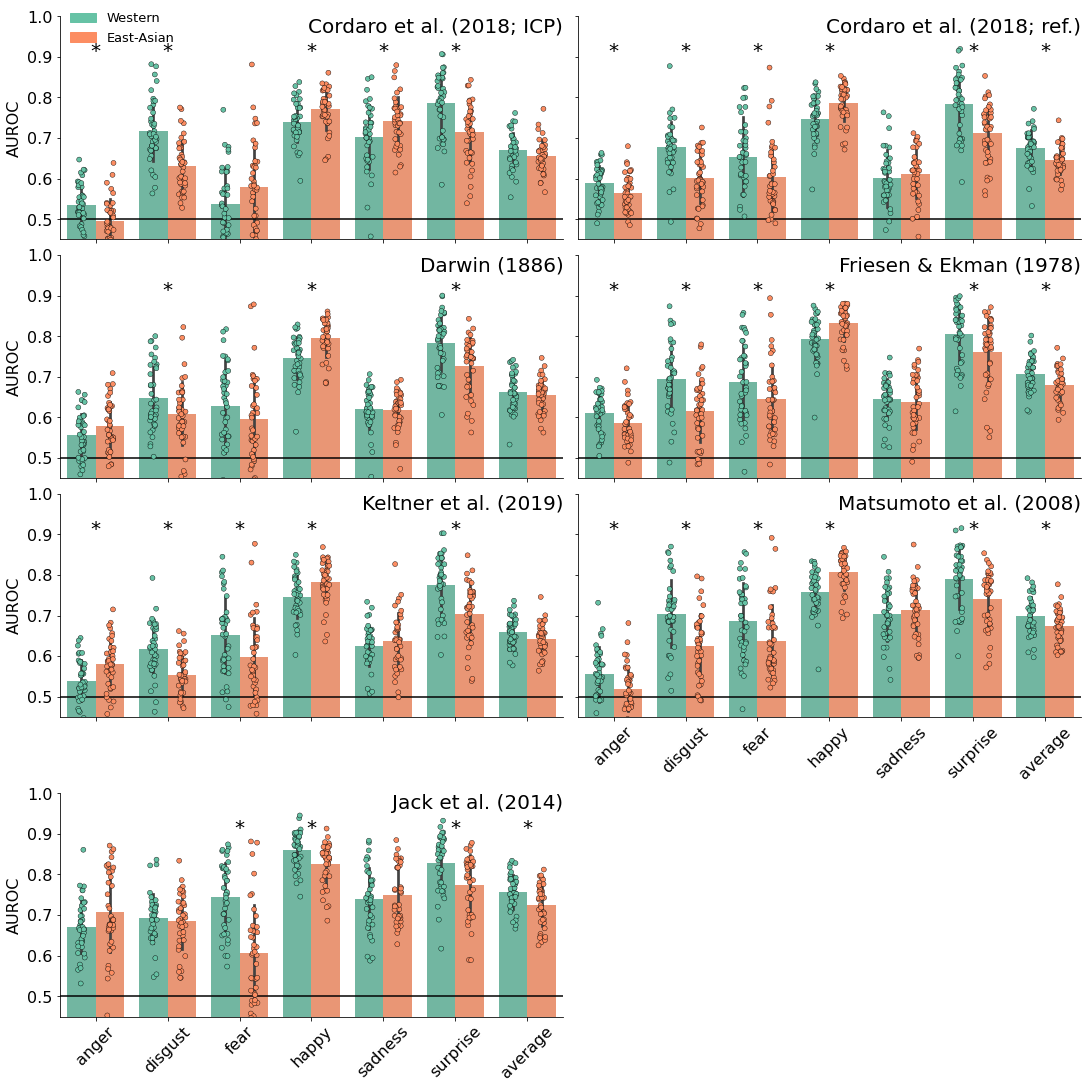

In [5]:
fig, axes = plt.subplots(figsize=(15, 15), constrained_layout=True, sharex=False, sharey=True, nrows=4, ncols=2)
hue_order = ['WC', 'EA']
for i, mapp in enumerate(df['mapping'].unique()):
    ax = axes.flatten()[i]
    this_df = df.query("mapping == @mapp")

    ax = sns.barplot(x='emotion', y='score', data=this_df, hue='sub_ethnicity', palette='Set2',
                    ax=ax, ci='sd', hue_order=hue_order, order=emo_names + ['average'])

    ax = sns.stripplot(x='emotion', y='score', hue='sub_ethnicity', palette='Set2',
                    edgecolor='black', linewidth=0.4, data=this_df, ax=ax,
                    dodge=True, jitter=True, hue_order=hue_order, order=emo_names + ['average'])

    ax.set_xlabel('')
    ax.legend_.remove()
    
    # Some aesthetics
    ax.set_facecolor('white')
    ax.set_ylim(0.45, 1)
    ax.axhline(0.5, c='k', ls='-')
    
    if i == 0:
        colors = {name: sns.color_palette('Set2')[i] for i, name in enumerate(['Western', 'East-Asian'])}
        labels = list(colors.keys())
        handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
        legend = ax.legend(handles, labels, loc=(0.01, 0.85), frameon=False, fontsize=13)

    ax.tick_params(axis='y', labelsize=16)
    ax.text(6.5, 0.975, mapp.replace('\n', ' '), fontsize=20, ha='right', va='center')
    if i in [5, 6]:
        ax.tick_params(axis='x', labelsize=16, rotation=45)
    else:
        ax.set_xticklabels([])
    
    if i % 2 == 0:
        ax.set_ylabel("AUROC", fontsize=16, labelpad=5)
    else:
        ax.set_ylabel('')
    for ii, emo in enumerate(emo_names + ['average']):
        ea = this_df.query("emotion == @emo & sub_ethnicity == 'EA'")
        wc = this_df.query("emotion == @emo & sub_ethnicity == 'WC'")
        tval, pval = ttest_ind(ea['score'].dropna(), wc['score'].dropna())
        #print(f"Emotion = {emo}, t-value: {tval:.3f}, p-value: {pval:.5f}")    
        if pval < 0.05:
            ax.text(ii, 0.9, '*', ha='center', fontsize=20)

axes[-1, -1].axis('off')
sns.despine()
fig.set_constrained_layout_pads(h_pad=0.25, w_pad=0.25)
plt.savefig('figure_S1.png', bbox_inches='tight', dpi=400, facecolor='white')

## Figure for reviewer about male/female faces
Plot performance separately for male and female faces.

In [6]:
df = pd.read_csv('../results/scores_face_gender.tsv', sep='\t', index_col=0)
df = df.replace(map2leg)

# Add average across emotions to df for plotting (rightmost panel)
df_av = df.groupby(['mapping', 'sub', 'sub_ethnicity', 'face_gender']).mean().reset_index()
df = pd.concat([df, df_av.assign(emotion='average')], axis=0)
df_av_map = df.groupby(['emotion', 'sub', 'face_gender', 'sub_ethnicity']).mean().reset_index()

Emotion = anger, t-value: -3.41, p-value: 0.00102, d = -0.41
Emotion = disgust, t-value: -5.42, p-value: 0.00000, d = -0.38
Emotion = fear, t-value: -0.89, p-value: 0.37538, d = -0.07
Emotion = happy, t-value: 0.81, p-value: 0.42039, d = 0.09
Emotion = sadness, t-value: -0.25, p-value: 0.80020, d = -0.03
Emotion = surprise, t-value: 4.72, p-value: 0.00001, d = 0.30
Emotion = average, t-value: -1.86, p-value: 0.06636, d = -0.12


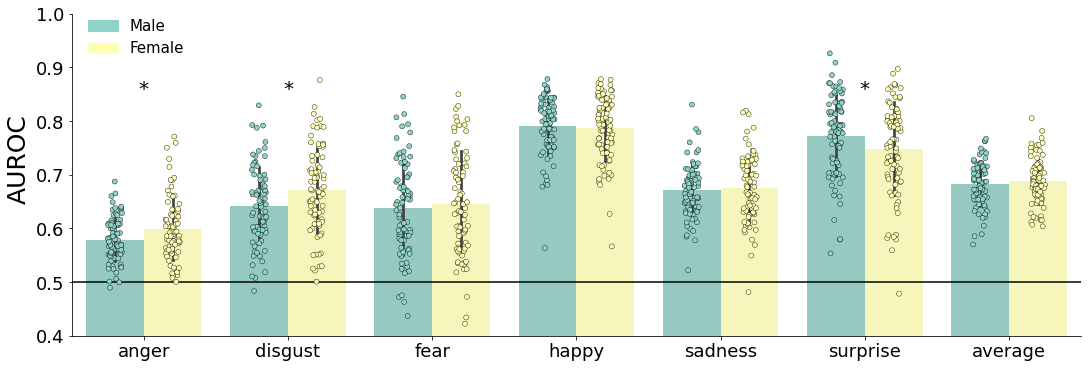

In [7]:
fig, ax2 = plt.subplots(figsize=(15, 5), constrained_layout=True)

hue_order = ['M', 'F']
ax2 = sns.barplot(x='emotion', y='score', data=df_av_map, hue='face_gender', palette='Set3',
                  ax=ax2, ci='sd', hue_order=hue_order, order=emo_names + ['average'])

ax2 = sns.stripplot(x='emotion', y='score', hue='face_gender', palette='Set3',
                   edgecolor='black', linewidth=0.4, data=df_av_map, ax=ax2,
                   dodge=True, jitter=True, hue_order=hue_order, order=emo_names + ['average'])

ax2.set_xlabel('')
ax2.set_ylabel('AUROC', fontsize=25, )
ax2.yaxis.set_label_coords(-0.04, 0.55)

# Some aesthetics
ax2.set_facecolor('white')
ax2.set_ylim(0.4, 1.)
ax2.axhline(0.5, c='k', ls='-')

colors = {name: sns.color_palette('Set3')[i] for i, name in enumerate(['Male', 'Female'])}
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
legend = ax2.legend(handles, labels, loc=(0.01, 0.85), frameon=False, fontsize=15)

ax2.tick_params(axis='y', labelsize=18)
ax2.tick_params(axis='x', labelsize=18)

for i, emo in enumerate(emo_names + ['average']):
    m_ = df_av_map.query("emotion == @emo & face_gender == 'M'")
    f_ = df_av_map.query("emotion == @emo & face_gender == 'F'")
    
    m_, f_ = m_['score'].fillna(0.5).to_numpy(), f_['score'].fillna(0.5).to_numpy()
    cohens_d = (m_.mean() - f_.mean()) / np.sqrt((m_.var() + f_.var()) / 2)
    
    tval, pval = ttest_rel(m_, f_)
    print(f"Emotion = {emo}, t-value: {tval:.2f}, p-value: {pval:.5f}, d = {cohens_d:.2f}")    
    if pval < 0.05:
        ax2.text(i, 0.85, '*', fontsize=20, ha='center')

sns.despine()
fig.set_constrained_layout_pads(h_pad=0.2)
plt.savefig('figure_SX_face_gender.png', dpi=200, facecolor='white')


## Main Figure 4: explanation

In [8]:
df_abl = pd.read_csv('../results/scores_ablation.tsv', sep='\t', index_col=0)
df_abl = df_abl.replace(map2leg).drop(['sub'], axis=1)

heatmaps_abl = {}
for ethn in ['all', 'WC', 'EA']:
    if ethn != 'all':
        df_abl_ethn = df_abl.query("sub_ethnicity == @ethn")
    else:
        df_abl_ethn = df_abl
    
    heatmap_abl = pd.DataFrame(np.zeros((6, 33)), columns=au_names, index=emo_names)
    for emo in emo_names:
        this_df = df_abl_ethn.query("score != 0 & ablated_from == @emo & emotion == @emo")
        this_df = this_df.groupby('ablated_au').mean().reset_index()
        for _, row in this_df.iterrows():
            heatmap_abl.loc[emo, row['ablated_au']] = row['score']

    heatmap_abl[heatmap_abl == 0] = np.nan
    heatmaps_abl[ethn] = heatmap_abl

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


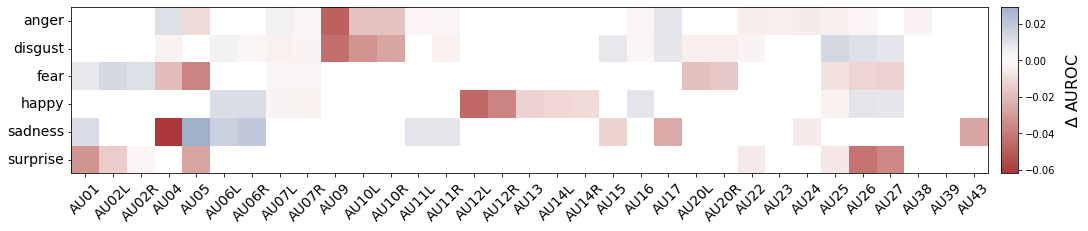

In [9]:
fig, ax = plt.subplots(figsize=(15, 5), constrained_layout=True)
ax = sns.heatmap(heatmaps_abl['all'], ax=ax, square=True, cmap='vlag_r', center=0, cbar_kws={'aspect': 10, 'shrink': 0.47, 'pad': 0.01})
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=45)
ax.set_yticklabels(emo_names, fontsize=14)
for sp in ['top', 'right', 'bottom', 'left']:
    ax.figure.axes[-1].spines[sp].set_visible(True)
    ax.spines[sp].set_visible(True)
    
ax.figure.axes[-1].set_ylabel(r'$\Delta$ AUROC', size=16, labelpad=10)
plt.savefig('figure_4.png', bbox_inches='tight', dpi=200, facecolor='white')


## Supplementary figure S2
Ablation results separately for each culture.

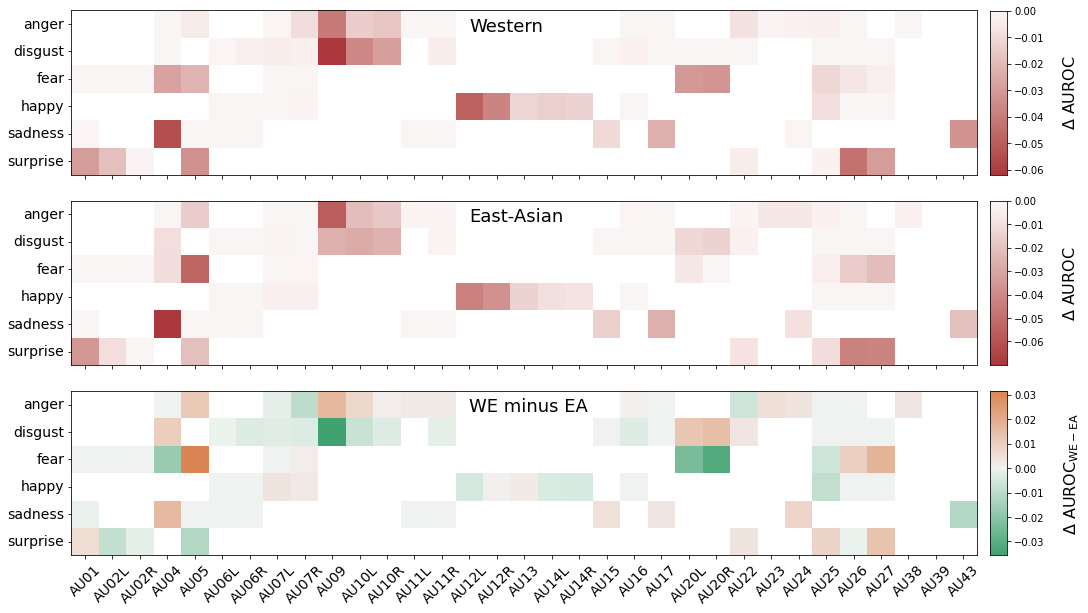

In [10]:
fig, axes = plt.subplots(figsize=(15, 8.5), nrows=3, constrained_layout=True)

for i, ethn in enumerate(['WC', 'EA', 'diff']):
    if ethn == 'diff':
        wc = heatmaps_abl['WC']
        wc[wc > 0] = 0
        ea = heatmaps_abl['EA']
        ea[ea > 0] = 0
        this_hm = wc - ea
        cmap = sns.diverging_palette(145, 390, s=80, l=60, n=100, as_cmap=True)
    else:
        this_hm = heatmaps_abl[ethn]
        this_hm[this_hm > 0] = 0
        cmap = 'vlag_r'
    
    ax = axes[i]
    
    ax = sns.heatmap(this_hm, square=True, ax=ax, cmap=cmap, center=0, cbar_kws={'aspect': 10, 'shrink': 0.89, 'pad': 0.01})
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=45)
    ax.set_yticklabels(emo_names, fontsize=14)
    
    if i < 2:
        ax.figure.axes[-1].set_ylabel(r'$\Delta$ AUROC', size=16, labelpad=18)
    else:
        ax.figure.axes[-1].set_ylabel(r'$\Delta\ \mathrm{AUROC}_{\mathrm{WE - EA}}$', size=16, labelpad=18)
    
    for sp in ['top', 'right', 'bottom', 'left']:
        ax.figure.axes[-1].spines[sp].set_visible(True)
        ax.spines[sp].set_visible(True)
        
    if i != 2:
        ax.set_xticklabels([])

    txt = {'WC': 'Western', 'EA': 'East-Asian', 'diff': 'WE minus EA'}
    ax.text(14.5, 0.25, txt[ethn], ha='left', va='top', fontsize=18)
    ax.set_yticklabels(emo_names, fontsize=14)

ax.set_xticklabels(ax.get_xticklabels(), fontsize=14, rotation=45)
fig.savefig('figure_S2.png', bbox_inches='tight', dpi=200)

## Main figure 5: exploration

In [11]:
df_o = pd.read_csv('../results/scores_optimal.tsv', sep='\t', index_col=0)
# Extract culture-accented model results
df_o = df_o.query("(model_ethnicity == 'EA' & sub_ethnicity == 'EA') | (model_ethnicity == 'WC' & sub_ethnicity == 'WC')")
df_o = df_o.replace(map2leg)
df_o = df_o.replace({'JackSchyns_ethn-all_CV': 'Jack et al.\n(2014)'})
df_o = pd.concat([
    df_o,
    df_o.groupby(['mapping', 'sub', 'sub_ethnicity', 'model_ethnicity']).mean().reset_index().assign(emotion='average')],
    axis=0)

df_o_av = df_o.groupby(['mapping', 'emotion']).mean().reset_index()

nc = pd.read_csv('../results/noise_ceiling.tsv', sep='\t', index_col=0)
nc = pd.concat((nc, nc.groupby(['sub_ethnicity', 'sub_split', 'trial_split']).mean().reset_index().assign(emotion='average')), axis=0)
nc_ = nc.query("sub_split == 'test' & trial_split == 'test' & sub_ethnicity == 'all'")

Emotion = anger, t-value: -0.279, p-value: 0.78187
Emotion = disgust, t-value: -1.428, p-value: 0.16160
Emotion = fear, t-value: 1.585, p-value: 0.12126
Emotion = happy, t-value: 1.278, p-value: 0.20905
Emotion = sadness, t-value: -0.267, p-value: 0.79104
Emotion = surprise, t-value: 2.000, p-value: 0.05274
Emotion = average, t-value: 0.762, p-value: 0.45098


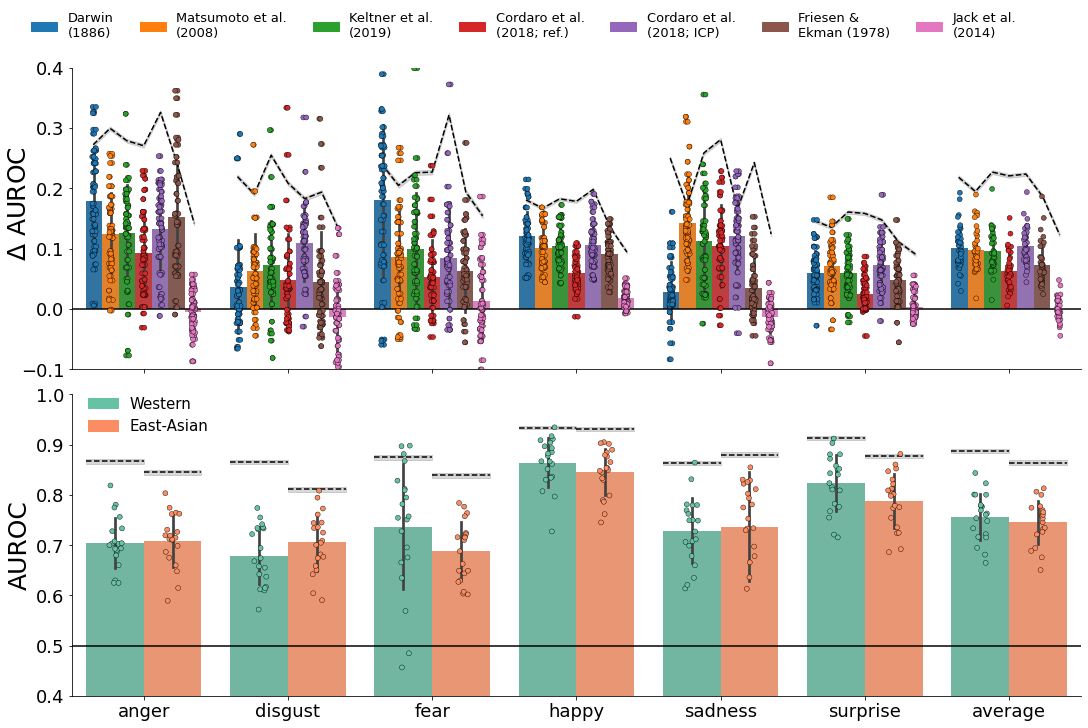

In [12]:
# NEW FIGURE
fig, axes = plt.subplots(figsize=(15, 10), constrained_layout=True, nrows=2, sharex=True)
ax1 = axes[0]
ax1 = sns.barplot(x='emotion', y='diff_score', data=df_o, hue='mapping',
                 ax=ax1, ci='sd')

ax1 = sns.stripplot(x='emotion', y='diff_score', hue='mapping', ax=ax1,
                    edgecolor='black', linewidth=0.4, data=df_o,
                    dodge=True, jitter=True)
            
ax1.set_ylabel(r'$\Delta$ AUROC', fontsize=25)
nc_ = nc.query("sub_ethnicity == 'all' & sub_split == 'test' & trial_split == 'test'")
for i, emo in enumerate(emo_names + ['average']):
    orig = df_o_av.query("emotion == @emo").set_index('mapping').loc[map_names, 'orig_score'].to_numpy()
    this_nc = nc_.query("emotion == @emo")['noise_ceiling'].item() - orig
    this_sd = nc_.query("emotion == @emo")['sd'].item()
    ax1.plot(np.linspace(i - 0.35, i + 0.35, num=7), this_nc, ls='--', c='k')
    ax1.fill_between(
        np.linspace(i-0.35, i+0.35, num=7),
        this_nc - this_sd, this_nc + this_sd,
        color='gray', alpha=0.3
    )

ax1.set_facecolor('white')
ax1.set_ylim(-0.1, 0.4)
ax1.axhline(0.5, c='k', ls='-')
ax1.legend_.remove()
colors = {mapp: sns.color_palette()[i] for i, mapp in enumerate(map_names)}
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
ax1.legend(handles, labels, ncol=7, loc=(-0.045, 1.075), frameon=False, fontsize=13)
ax1.yaxis.set_label_coords(-0.04, 0.55)

ax1.set_xlim(-0.5, 6.75)
ax1.set_xlabel('')
ax1.axhline(0, c='k')
ax1.tick_params(axis='y', labelsize=18)
ax1.tick_params(axis='x', labelsize=18)

ax2 = axes[1]
df_av_map = df_o.groupby(['emotion', 'sub_ethnicity', 'sub']).mean().reset_index()
hue_order = ['WC', 'EA']
ax2 = sns.barplot(x='emotion', y='opt_score', data=df_av_map, hue='sub_ethnicity', palette='Set2',
                 ax=ax2, ci='sd', hue_order=hue_order, order=emo_names + ['average'])

ax2 = sns.stripplot(x='emotion', y='opt_score', hue='sub_ethnicity', palette='Set2',
                   edgecolor='black', linewidth=0.4, data=df_av_map, ax=ax2,
                   dodge=True, jitter=True, hue_order=hue_order, order=emo_names + ['average'])

ax2.set_xlabel('')
ax2.set_ylabel('AUROC', fontsize=25, )
#ax2.yaxis.set_label_coords(-0.04, 0.55)

# Some aesthetics
ax2.set_facecolor('white')
ax2.set_ylim(0.4, 1.)
ax2.axhline(0.5, c='k', ls='-')

colors = {name: sns.color_palette('Set2')[i] for i, name in enumerate(['Western', 'East-Asian'])}
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
legend = ax2.legend(handles, labels, loc=(0.01, 0.85), frameon=False, fontsize=15)

ax2.tick_params(axis='y', labelsize=18)
ax2.tick_params(axis='x', labelsize=18)

for i, emo in enumerate(emo_names + ['average']):
    ea = df_av_map.query("emotion == @emo & sub_ethnicity == 'EA'")
    wc = df_av_map.query("emotion == @emo & sub_ethnicity == 'WC'")
    tval, pval = ttest_ind(wc['opt_score'].dropna(), ea['opt_score'].dropna())
    print(f"Emotion = {emo}, t-value: {tval:.3f}, p-value: {pval:.5f}")    
    if pval < 0.05:
        ax2.text(i, 0.9, '*', fontsize=20)
        
for i, emo in enumerate(emo_names + ['average']):
    
    for ii, ethn in enumerate(['WC', 'EA']):
        nc_ = nc.query("sub_split == 'test' & trial_split == 'test' & sub_ethnicity == @ethn & emotion == @emo")
        this_nc = nc_['noise_ceiling'].item()
        this_sd = nc_['sd'].item()
        ax2.plot(np.linspace(i-0.4 + ii * 0.4, i + ii * 0.4, num=7), [this_nc] * 7, c='k', ls='--')

        ax2.fill_between(
            np.linspace(i-0.4 + ii * 0.4, i + ii * 0.4, num=7),
            this_nc - this_sd, this_nc + this_sd,
            color='gray', alpha=0.3
        )

sns.despine()
fig.set_constrained_layout_pads(h_pad=0.25)
plt.savefig('figure_5.png', dpi=100, facecolor='white', bbox_inches='tight')


In [18]:
df_av_map.groupby(['emotion', 'sub_ethnicity']).mean()

orig_score  opt_score  diff_score
emotion  sub_ethnicity                                   
anger    EA               0.596433   0.709093    0.112660
         WC               0.587075   0.704483    0.117408
average  EA               0.660849   0.745233    0.084384
         WC               0.687568   0.756167    0.068600
disgust  EA               0.618589   0.705566    0.086977
         WC               0.662917   0.678945    0.016028
fear     EA               0.596199   0.687305    0.091105
         WC               0.662191   0.736986    0.074795
happy    EA               0.755693   0.844935    0.089242
         WC               0.782162   0.864412    0.082250
sadness  EA               0.661403   0.736457    0.075053
         WC               0.653340   0.728709    0.075369
surprise EA               0.736776   0.788043    0.051267
         WC               0.777722   0.823469    0.045747

## Supplementary figure S5
Exploration results with culture-agnostic models.

Emotion = anger, t-value: -0.76, p-value: 0.44698, d = -0.17
Emotion = disgust, t-value: 2.74, p-value: 0.00767, d = 0.62
Emotion = fear, t-value: 2.02, p-value: 0.04692, d = 0.46
Emotion = happy, t-value: -0.91, p-value: 0.36423, d = -0.21
Emotion = sadness, t-value: -0.56, p-value: 0.57429, d = -0.13
Emotion = surprise, t-value: 2.28, p-value: 0.02549, d = 0.52
Emotion = average, t-value: 1.55, p-value: 0.12429, d = 0.35


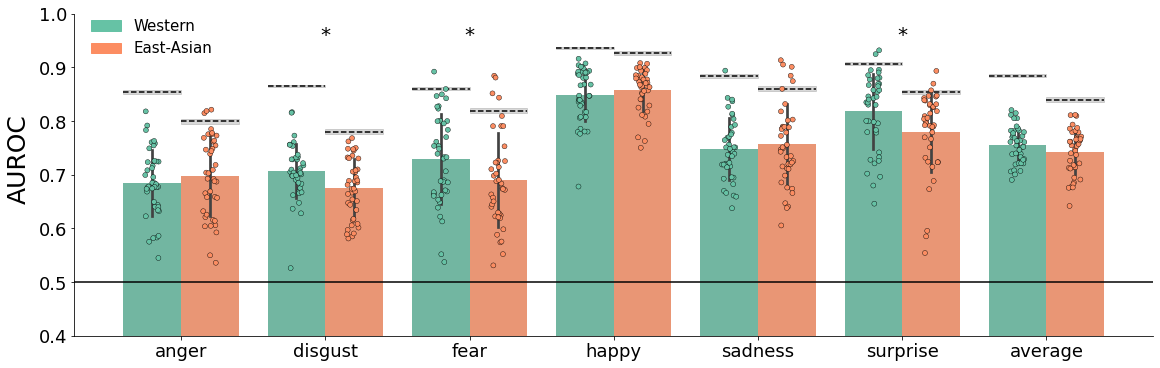

In [22]:
fig, ax2 = plt.subplots(figsize=(16, 5), constrained_layout=True)

df_o = pd.read_csv('../results/scores_optimal_train.tsv', sep='\t', index_col=0)
df_o = df_o.replace(map2leg)
df_o = df_o.replace({'JackSchyns_ethn-all_CV': 'Jack et al.\n(2014)'})
df_o = df_o.query("model_ethnicity == 'all'")
df_o = pd.concat([
    df_o,
    df_o.groupby(['mapping', 'sub', 'sub_ethnicity', 'model_ethnicity']).mean().reset_index().assign(emotion='average')],
    axis=0)

df_o_av = df_o.groupby(['mapping', 'emotion']).mean().reset_index()
df_av_map = df_o.groupby(['emotion', 'sub_ethnicity', 'sub']).mean().reset_index()

hue_order = ['WC', 'EA']
ax2 = sns.barplot(x='emotion', y='opt_score', data=df_av_map, hue='sub_ethnicity', palette='Set2',
                 ax=ax2, ci='sd', hue_order=hue_order, order=emo_names + ['average'])

ax2 = sns.stripplot(x='emotion', y='opt_score', hue='sub_ethnicity', palette='Set2',
                   edgecolor='black', linewidth=0.4, data=df_av_map, ax=ax2,
                   dodge=True, jitter=True, hue_order=hue_order, order=emo_names + ['average'])

ax2.set_xlabel('')
ax2.set_ylabel('AUROC', fontsize=25, )
ax2.yaxis.set_label_coords(-0.04, 0.55)

# Some aesthetics
ax2.set_facecolor('white')
ax2.set_ylim(0.4, 1.)
ax2.axhline(0.5, c='k', ls='-')

colors = {name: sns.color_palette('Set2')[i] for i, name in enumerate(['Western', 'East-Asian'])}
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
legend = ax2.legend(handles, labels, loc=(0.01, 0.85), frameon=False, fontsize=15)

ax2.tick_params(axis='y', labelsize=18)
ax2.tick_params(axis='x', labelsize=18)

for i, emo in enumerate(emo_names + ['average']):
    ea = df_av_map.query("emotion == @emo & sub_ethnicity == 'EA'")
    wc = df_av_map.query("emotion == @emo & sub_ethnicity == 'WC'")
    
    wc_, ea_ = wc['opt_score'].dropna().to_numpy(), ea['opt_score'].dropna().to_numpy()
    cohens_d = (wc_.mean() - ea_.mean()) / np.sqrt((wc_.var() + ea_.var()) / 2)
    
    tval, pval = ttest_ind(wc['opt_score'].dropna(), ea['opt_score'].dropna())
    print(f"Emotion = {emo}, t-value: {tval:.2f}, p-value: {pval:.5f}, d = {cohens_d:.2f}")    
    if pval < 0.05:
        ax2.text(i, 0.95, '*', fontsize=20, ha='center')
        
for i, emo in enumerate(emo_names + ['average']):
    
    for ii, ethn in enumerate(['WC', 'EA']):
        nc_ = nc.query("sub_split == 'train' & trial_split == 'train' & sub_ethnicity == @ethn & emotion == @emo")
        this_nc = nc_['noise_ceiling'].item()
        this_sd = nc_['sd'].item()
        ax2.plot(np.linspace(i-0.4 + ii * 0.4, i + ii * 0.4, num=7), [this_nc] * 7, c='k', ls='--')

        ax2.fill_between(
            np.linspace(i-0.4 + ii * 0.4, i + ii * 0.4, num=7),
            this_nc - this_sd, this_nc + this_sd,
            color='gray', alpha=0.3
        )

sns.despine()
fig.set_constrained_layout_pads(h_pad=0.2)
plt.savefig('figure_S5.png', dpi=400, facecolor='white')


## Supplementary figure S6
Culture-accented vs. culture-agnostic performance.

Emotion = anger, t-value: -1.77, p-value: 0.08472, d = -0.11
Emotion = disgust, t-value: -0.05, p-value: 0.95922, d = -0.01
Emotion = fear, t-value: -2.05, p-value: 0.04684, d = -0.09
Emotion = happy, t-value: -8.35, p-value: 0.00000, d = -0.35
Emotion = sadness, t-value: 4.03, p-value: 0.00025, d = 0.14
Emotion = surprise, t-value: -3.37, p-value: 0.00168, d = -0.23
Emotion = average, t-value: -2.38, p-value: 0.02228, d = -0.15


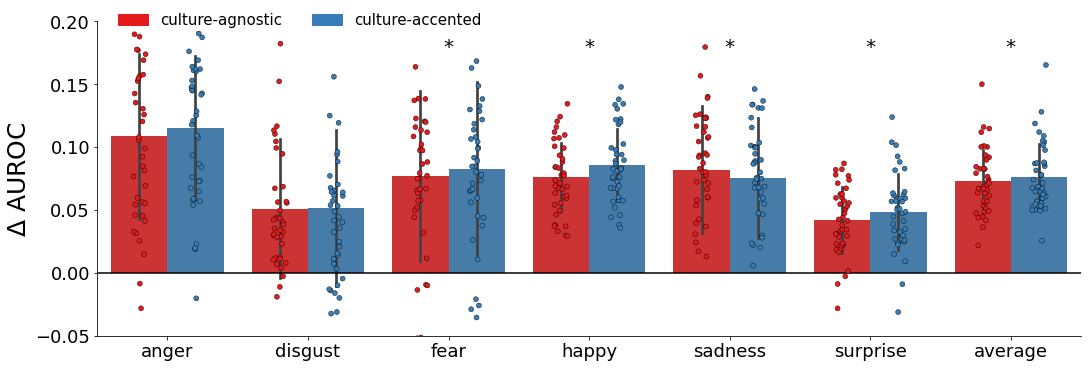

In [23]:
df_o = pd.read_csv('../results/scores_optimal.tsv', sep='\t', index_col=0)
df_o = df_o.query("(model_ethnicity == 'EA' & sub_ethnicity == 'EA') | (model_ethnicity == 'WC' & sub_ethnicity == 'WC')")
df_o = df_o.replace(map2leg)
df_o = df_o.replace({'JackSchyns_ethn-all_CV': 'Jack et al.\n(2014)'})
df_o = pd.concat([
    df_o,
    df_o.groupby(['mapping', 'sub', 'sub_ethnicity', 'model_ethnicity']).mean().reset_index().assign(emotion='average')],
    axis=0)
df_o['model_type'] = 'culture-specific'

df_o2 = pd.read_csv('../results/scores_optimal.tsv', sep='\t', index_col=0)
df_o2 = df_o2.query("model_ethnicity == 'all'")
df_o2 = df_o2.replace(map2leg)
df_o2 = df_o2.replace({'JackSchyns_ethn-all_CV': 'Jack et al.\n(2014)'})
df_o2 = pd.concat([
    df_o2,
    df_o2.groupby(['mapping', 'sub', 'sub_ethnicity', 'model_ethnicity']).mean().reset_index().assign(emotion='average')],
    axis=0)
df_o2['model_type'] = 'culture-ignorant'
df_o = pd.concat((df_o, df_o2), axis=0)

fig, ax = plt.subplots(figsize=(15, 5), constrained_layout=True)
df_av_map = df_o.groupby(['emotion', 'sub_ethnicity', 'sub', 'model_type']).mean().reset_index()
ax = sns.barplot(x='emotion', y='diff_score', data=df_av_map, hue='model_type', palette='Set1',
                 ax=ax, ci='sd', hue_order=['culture-ignorant', 'culture-specific'], order=emo_names + ['average'])

ax = sns.stripplot(x='emotion', y='diff_score', hue='model_type', palette='Set1',
                   edgecolor='black', linewidth=0.4, data=df_av_map, ax=ax,
                   dodge=True, jitter=True, hue_order=['culture-ignorant', 'culture-specific'], order=emo_names + ['average'])
ax.set_ylim(-0.05, 0.2)

# Some aesthetics
ax.set_facecolor('white')
ax.axhline(0, c='k', ls='-')

colors = {name: sns.color_palette('Set1')[i] for i, name in enumerate(['culture-agnostic', 'culture-accented'])}
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
legend = ax.legend(handles, labels, loc=(0.015, 0.96), frameon=False, fontsize=15, ncol=2)
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=18)
ax.set_ylabel('$\Delta\ \mathrm{AUROC}$', fontsize=25)
ax.set_xlabel('')

for i, emo in enumerate(emo_names + ['average']):
    ci = df_av_map.query("emotion == @emo & model_type == 'culture-ignorant'")
    cs = df_av_map.query("emotion == @emo & model_type == 'culture-specific'")
    
    ci_, cs_ = ci['diff_score'].dropna().to_numpy(), cs['diff_score'].dropna().to_numpy()
    cohens_d = (ci_.mean() - cs_.mean()) / np.sqrt((ci_.var() + cs_.var()) / 2)
    tval, pval = ttest_rel(ci_, cs_)
    print(f"Emotion = {emo}, t-value: {tval:.2f}, p-value: {pval:.5f}, d = {cohens_d:.2f}")    
    if pval < 0.05:
        ax.text(i, 0.175, '*', fontsize=20, ha='center')

sns.despine()
plt.savefig('figure_S6.png', dpi=400, facecolor='white')


## Supplementary figure SX
Exploration results on train set.

In [26]:
df_o = pd.read_csv('../results/scores_optimal_train.tsv', sep='\t', index_col=0)
# Extract culture-accented model results
df_o = df_o.query("(model_ethnicity == 'EA' & sub_ethnicity == 'EA') | (model_ethnicity == 'WC' & sub_ethnicity == 'WC')")
df_o = df_o.replace(map2leg)
df_o = df_o.replace({'JackSchyns_ethn-all_CV': 'Jack et al.\n(2014)'})
df_o = pd.concat([
    df_o,
    df_o.groupby(['mapping', 'sub', 'sub_ethnicity', 'model_ethnicity']).mean().reset_index().assign(emotion='average')],
    axis=0)

df_o_av = df_o.groupby(['mapping', 'emotion']).mean().reset_index()

nc = pd.read_csv('../results/noise_ceiling.tsv', sep='\t', index_col=0)
nc = pd.concat((nc, nc.groupby(['sub_ethnicity', 'sub_split', 'trial_split']).mean().reset_index().assign(emotion='average')), axis=0)
nc_ = nc.query("sub_split == 'train' & trial_split == 'train' & sub_ethnicity == 'all'")

Emotion = anger, t-value: 0.764, p-value: 0.44717, d: 0.173
Emotion = disgust, t-value: 1.874, p-value: 0.06462, d: 0.424
Emotion = fear, t-value: 1.588, p-value: 0.11641, d: 0.360
Emotion = happy, t-value: -0.968, p-value: 0.33618, d: -0.219
Emotion = sadness, t-value: -0.316, p-value: 0.75259, d: -0.072
Emotion = surprise, t-value: 2.137, p-value: 0.03572, d: 0.484
Emotion = average, t-value: 1.618, p-value: 0.10975, d: 0.366


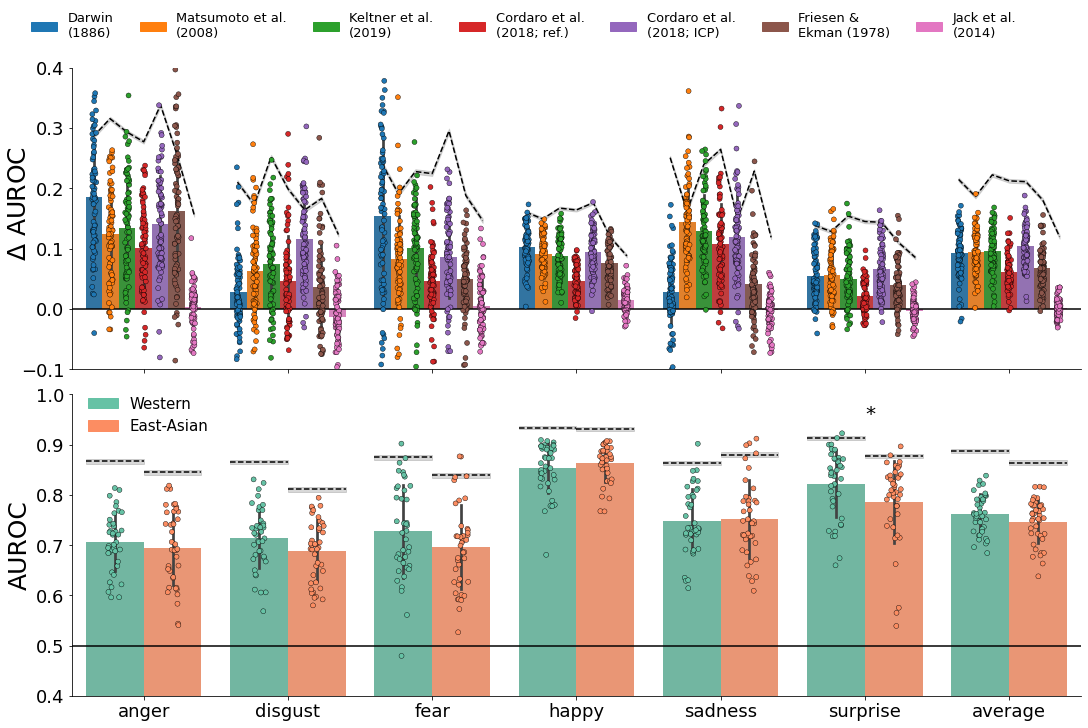

In [30]:
# NEW FIGURE
fig, axes = plt.subplots(figsize=(15, 10), constrained_layout=True, nrows=2, sharex=True)
ax1 = axes[0]
ax1 = sns.barplot(x='emotion', y='diff_score', data=df_o, hue='mapping',
                 ax=ax1, ci='sd')

ax1 = sns.stripplot(x='emotion', y='diff_score', hue='mapping', ax=ax1,
                    edgecolor='black', linewidth=0.4, data=df_o,
                    dodge=True, jitter=True)
            
ax1.set_ylabel(r'$\Delta$ AUROC', fontsize=25)
nc_ = nc.query("sub_ethnicity == 'all' & sub_split == 'test' & trial_split == 'test'")
for i, emo in enumerate(emo_names + ['average']):
    orig = df_o_av.query("emotion == @emo").set_index('mapping').loc[map_names, 'orig_score'].to_numpy()
    this_nc = nc_.query("emotion == @emo")['noise_ceiling'].item() - orig
    this_sd = nc_.query("emotion == @emo")['sd'].item()
    ax1.plot(np.linspace(i - 0.35, i + 0.35, num=7), this_nc, ls='--', c='k')
    ax1.fill_between(
        np.linspace(i-0.35, i+0.35, num=7),
        this_nc - this_sd, this_nc + this_sd,
        color='gray', alpha=0.3
    )

ax1.set_facecolor('white')
ax1.set_ylim(-0.1, 0.4)
ax1.axhline(0.5, c='k', ls='-')
ax1.legend_.remove()
colors = {mapp: sns.color_palette()[i] for i, mapp in enumerate(map_names)}
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
ax1.legend(handles, labels, ncol=7, loc=(-0.045, 1.075), frameon=False, fontsize=13)
ax1.yaxis.set_label_coords(-0.04, 0.55)

ax1.set_xlim(-0.5, 6.75)
ax1.set_xlabel('')
ax1.axhline(0, c='k')
ax1.tick_params(axis='y', labelsize=18)
ax1.tick_params(axis='x', labelsize=18)

ax2 = axes[1]
df_av_map = df_o.groupby(['emotion', 'sub_ethnicity', 'sub']).mean().reset_index()
hue_order = ['WC', 'EA']
ax2 = sns.barplot(x='emotion', y='opt_score', data=df_av_map, hue='sub_ethnicity', palette='Set2',
                 ax=ax2, ci='sd', hue_order=hue_order, order=emo_names + ['average'])

ax2 = sns.stripplot(x='emotion', y='opt_score', hue='sub_ethnicity', palette='Set2',
                   edgecolor='black', linewidth=0.4, data=df_av_map, ax=ax2,
                   dodge=True, jitter=True, hue_order=hue_order, order=emo_names + ['average'])

ax2.set_xlabel('')
ax2.set_ylabel('AUROC', fontsize=25, )
#ax2.yaxis.set_label_coords(-0.04, 0.55)

# Some aesthetics
ax2.set_facecolor('white')
ax2.set_ylim(0.4, 1.)
ax2.axhline(0.5, c='k', ls='-')

colors = {name: sns.color_palette('Set2')[i] for i, name in enumerate(['Western', 'East-Asian'])}
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
legend = ax2.legend(handles, labels, loc=(0.01, 0.85), frameon=False, fontsize=15)

ax2.tick_params(axis='y', labelsize=18)
ax2.tick_params(axis='x', labelsize=18)

for i, emo in enumerate(emo_names + ['average']):
    ea = df_av_map.query("emotion == @emo & sub_ethnicity == 'EA'")
    wc = df_av_map.query("emotion == @emo & sub_ethnicity == 'WC'")
    wc_, ea_ = wc['opt_score'].dropna().to_numpy(), ea['opt_score'].dropna().to_numpy()
    cohens_d = (wc_.mean() - ea_.mean()) / np.sqrt((wc_.var() + ea_.var()) / 2)
    tval, pval = ttest_ind(wc_, ea_)
    print(f"Emotion = {emo}, t-value: {tval:.3f}, p-value: {pval:.5f}, d: {cohens_d:.3f}")    
    if pval < 0.05:
        ax2.text(i, 0.95, '*', fontsize=20)
        
for i, emo in enumerate(emo_names + ['average']):
    
    for ii, ethn in enumerate(['WC', 'EA']):
        nc_ = nc.query("sub_split == 'test' & trial_split == 'test' & sub_ethnicity == @ethn & emotion == @emo")
        this_nc = nc_['noise_ceiling'].item()
        this_sd = nc_['sd'].item()
        ax2.plot(np.linspace(i-0.4 + ii * 0.4, i + ii * 0.4, num=7), [this_nc] * 7, c='k', ls='--')

        ax2.fill_between(
            np.linspace(i-0.4 + ii * 0.4, i + ii * 0.4, num=7),
            this_nc - this_sd, this_nc + this_sd,
            color='gray', alpha=0.3
        )

sns.despine()
fig.set_constrained_layout_pads(h_pad=0.25)
plt.savefig('figure_SX_exploration_train.png', dpi=100, facecolor='white', bbox_inches='tight')

In [28]:
df_av_map.groupby(['emotion', 'sub_ethnicity']).mean()

orig_score  opt_score  diff_score
emotion  sub_ethnicity                                   
anger    EA               0.574187   0.695001    0.120814
         WC               0.583232   0.706515    0.123283
average  EA               0.670784   0.746973    0.076188
         WC               0.690841   0.762075    0.071234
disgust  EA               0.618432   0.689125    0.070693
         WC               0.685038   0.714969    0.029931
fear     EA               0.618733   0.696062    0.077329
         WC               0.655096   0.727843    0.072747
happy    EA               0.804565   0.863014    0.058448
         WC               0.765361   0.853543    0.088182
sadness  EA               0.673707   0.752100    0.078393
         WC               0.663905   0.746997    0.083092
surprise EA               0.735081   0.786534    0.051453
         WC               0.792412   0.822581    0.030169

## Supplementary Figure 3
Ablation results per model

In [ ]:
df_abl = pd.read_csv('../results/scores_ablation.tsv', sep='\t', index_col=0)
df_abl = df_abl.replace(map2leg).drop('sub', axis=1)
df_abl['mapping'] = df_abl['mapping'].replace({'JackSchyns_ethn-all_CV': 'Jack et al.\n(2014)'})

fig, axes = plt.subplots(nrows=6, figsize=(16, 10), sharey=True, sharex=False,
                         constrained_layout=True)
for i, emo in enumerate(emo_names):
    this_df = df_abl.query("ablated_from == @emo & emotion == @emo")
    axes[i] = sns.barplot(x='ablated_au', y='score', data=this_df, hue='mapping',
                          ci=95, errwidth=1, ax=axes[i])
    if i != 0:
        axes[i].get_legend().remove()
    else:
        axes[i].legend(ncol=7, loc=(0.2, 1.05), frameon=False)

    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)
    axes[i].text(31, 0.04, emo.capitalize(), fontsize=20, ha='center', va='center')
    axes[i].axhline(0, ls='-', c='k', lw=0.25)

axes[i].set_ylim(-0.07, 0.05)
fig.text(-0.02, 0.5, r'$\Delta$ AUROC', va='center', ha='center',
         rotation='vertical', fontsize=30)
fig.text(0.5, -0.04, 'Ablated AU', va='center', ha='center', fontsize=30)

sns.despine()
fig.savefig('figure_S3.png', dpi=400, facecolor='white')

## Supplementary Figure S4

/tmp/ipykernel_53687/1027415435.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(), size=12)


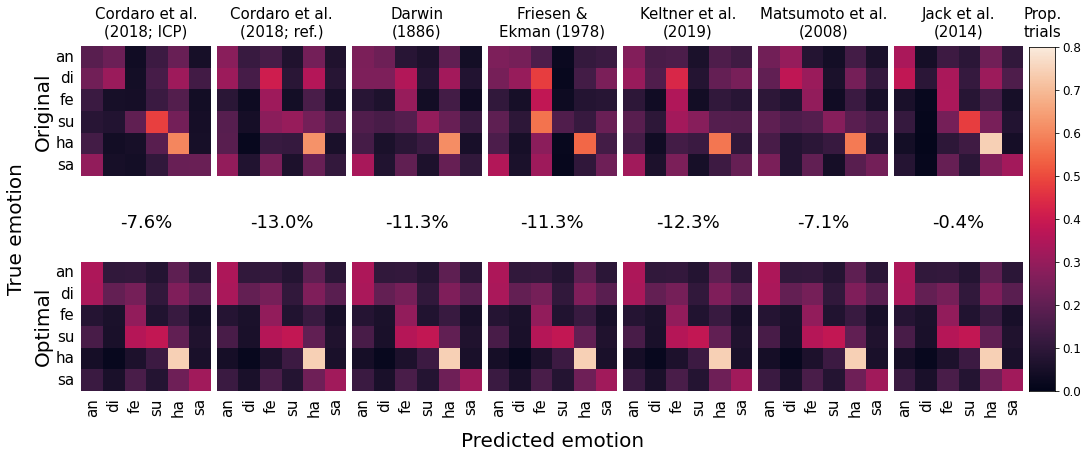

In [33]:
# CM PLOTS
# CM stuff
cm_df = pd.read_csv('../results/cm_optimal.tsv', sep='\t', index_col=0).query("model_ethnicity == 'all' & sub_ethnicity == 'all'")
cm_df = cm_df.replace(map2leg)
cm_df = cm_df.replace({'JackSchyns_ethn-all_CV': 'Jack et al.\n(2014)'})
emo_reorder = ['anger', 'disgust', 'fear', 'surprise', 'happy', 'sadness']
emo_short = ['an', 'di', 'fe', 'su', 'ha', 'sa']

fig = plt.figure(figsize=(15, 10), constrained_layout=True)
gs = fig.add_gridspec(3, 8, height_ratios=[3, 2, 2], width_ratios=[1, 1, 1, 1, 1, 1, 1, 0.2])
axes = [[fig.add_subplot(gs[ii, i]) for i in range(7)] for ii in range(1, 3)]
cbar_ax = fig.add_subplot(gs[1:, 7])
I = np.eye(6)
for i, mapp in enumerate(cm_df['mapping'].unique()):
    bg = np.zeros(2)
    for ii, tpe in enumerate(['orig', 'opt']):
        cm = cm_df.query("mapping == @mapp & type == @tpe").drop(['mapping', 'type'], axis=1)
        cm = cm.loc[emo_reorder, emo_reorder].to_numpy()
        bg[ii] = (cm[np.triu_indices_from(cm, k=1)].sum() + cm[np.tril_indices_from(cm, k=-1)].sum()) / 30

        cm /= cm.sum(axis=1)
        
        xtl = emo_short if ii == 1 else False
        ytl = emo_short if i == 0 else False
        cbar = True if i == 6 and ii == 0 else False
        axes[ii][i] = sns.heatmap(
            cm, ax=axes[ii][i], vmin=0, vmax=0.8, square=True, cbar=cbar,
            xticklabels=xtl, yticklabels=ytl, cbar_ax=cbar_ax
        )
        if cbar:
            cbar_ax.set_title('Prop.\ntrials', size=15, pad=10)
            cbar_ax.set_yticklabels(cbar_ax.get_yticklabels(), size=12)
            cbar_ax.set_box_aspect(13.3)
            for axis in ['top','bottom','left','right']:
                cbar_ax.spines[axis].set_visible(True)
        
        if ii == 0:
            axes[ii][i].set_title(mapp, fontsize=15, pad=10)
        
        if ii == 1:
            axes[ii][i].set_xticklabels(axes[ii][i].get_xticklabels(), rotation=90, fontsize=15)

        if i == 0:
            axes[ii][i].set_yticklabels(axes[ii][i].get_yticklabels(), rotation=0, fontsize=15)

        axes[ii][i].tick_params(axis='x', which='both', bottom=False)
        axes[ii][i].tick_params(axis='y', which='both', left=False)
        #bg[ii] = 1 - (np.sum((cm - I) ** 2) / np.sum((1 - I) ** 2))
    
    delta_bg = (bg[1] - bg[0]) / bg[0] * 100
    axes[1][i].text(3, -1.8, f"{delta_bg:.1f}%", ha='center', va='center', fontsize=18)

axes[1][0].set_ylabel('True emotion', fontsize=20, ha='center', va='center')
axes[1][0].yaxis.set_label_coords(-0.5, 1.25)
axes[1][3].set_xlabel('Predicted emotion', fontsize=20, labelpad=15)
#axes[1][0].text(-0.5, -1.3, 'Conf.:', fontsize=20, ha='center', va='center')
axes[0][0].text(-1.75, 3, 'Original', fontsize=20, ha='center', va='center', rotation=90)
axes[1][0].text(-1.75, 3, 'Optimal', fontsize=20, ha='center', va='center', rotation=90)
plt.savefig('figure_S4.png', dpi=200, bbox_inches='tight')

In [34]:
from glob import glob
opt_models = pd.concat([pd.read_csv(f, sep='\t', index_col=0) for f in
                        glob('../results/opt_models/*')])
opt_models = opt_models.reset_index().rename({'index': 'emotion'}, axis=1)
au_cols = [c for c in opt_models.columns if 'AU' in c]
for model_ethn in ['all', 'WC', 'EA']:
    m = opt_models.query("model_ethnicity == @model_ethn").drop('model_ethnicity', axis=1)
    av = m.groupby(au_cols + ['emotion']).mean().reset_index()
    for i, emo in enumerate(emo_names):
        common_aus = av.query("emotion == @emo").iloc[0, :].loc[au_cols]
        print(f"Culture: {model_ethn}, {emo}: {common_aus[common_aus == 1].index.tolist()}")

Culture: all, anger: ['AU05', 'AU09', 'AU10L', 'AU10R', 'AU11L', 'AU16', 'AU22', 'AU23', 'AU24', 'AU25', 'AU38']
Culture: all, disgust: ['AU04', 'AU07L', 'AU07R', 'AU09', 'AU10L', 'AU10R', 'AU11R', 'AU16', 'AU20L', 'AU20R', 'AU22']
Culture: all, fear: ['AU04', 'AU05', 'AU20L', 'AU20R', 'AU25', 'AU26', 'AU27']
Culture: all, happy: ['AU07L', 'AU07R', 'AU12L', 'AU12R', 'AU13', 'AU14L', 'AU14R', 'AU25']
Culture: all, sadness: ['AU04', 'AU15', 'AU17', 'AU24', 'AU43']
Culture: all, surprise: ['AU01', 'AU02L', 'AU02R', 'AU05', 'AU22', 'AU25', 'AU26', 'AU27']
Culture: WC, anger: ['AU05', 'AU07L', 'AU07R', 'AU09', 'AU10L', 'AU10R', 'AU16', 'AU22', 'AU23', 'AU24', 'AU25']
Culture: WC, disgust: ['AU06L', 'AU06R', 'AU07L', 'AU07R', 'AU09', 'AU10L', 'AU10R', 'AU11R', 'AU16', 'AU22']
Culture: WC, fear: ['AU04', 'AU05', 'AU20L', 'AU20R', 'AU25', 'AU26', 'AU27']
Culture: WC, happy: ['AU07R', 'AU12L', 'AU12R', 'AU13', 'AU14L', 'AU14R', 'AU25']
Culture: WC, sadness: ['AU01', 'AU04', 'AU15', 'AU17', 'AU2

/home/lukass/miniconda3/envs/hka/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  exec(code_obj, self.user_global_ns, self.user_ns)


Does the optimization also work on the train set? (For reviewer comment)

In [22]:
df_o = pd.read_csv('../results/scores_optimal_train.tsv', sep='\t', index_col=0)
df_o = df_o.query("(model_ethnicity == 'EA' & sub_ethnicity == 'EA') | (model_ethnicity == 'WC' & sub_ethnicity == 'WC')")
df_o = df_o.replace(map2leg)
df_o = df_o.replace({'JackSchyns_ethn-all_CV': 'Jack et al.\n(2014)'})
df_o = pd.concat([
    df_o,
    df_o.groupby(['mapping', 'sub', 'sub_ethnicity', 'model_ethnicity']).mean().reset_index().assign(emotion='average')],
    axis=0)

df_o_av = df_o.groupby(['mapping', 'emotion']).mean().reset_index()

nc = pd.read_csv('../results/noise_ceiling.tsv', sep='\t', index_col=0)
nc = pd.concat((nc, nc.groupby(['sub_ethnicity', 'sub_split', 'trial_split']).mean().reset_index().assign(emotion='average')), axis=0)
nc_ = nc.query("sub_split == 'train' & trial_split == 'train' & sub_ethnicity == 'all'")

Emotion = anger, t-value: 0.764, p-value: 0.44712, d = 0.17
Emotion = disgust, t-value: 1.874, p-value: 0.06463, d = 0.42
Emotion = fear, t-value: 1.588, p-value: 0.11644, d = 0.36
Emotion = happy, t-value: -0.968, p-value: 0.33608, d = -0.22
Emotion = sadness, t-value: -0.316, p-value: 0.75287, d = -0.07
Emotion = surprise, t-value: 2.137, p-value: 0.03572, d = 0.48
Emotion = average, t-value: 1.618, p-value: 0.10974, d = 0.37


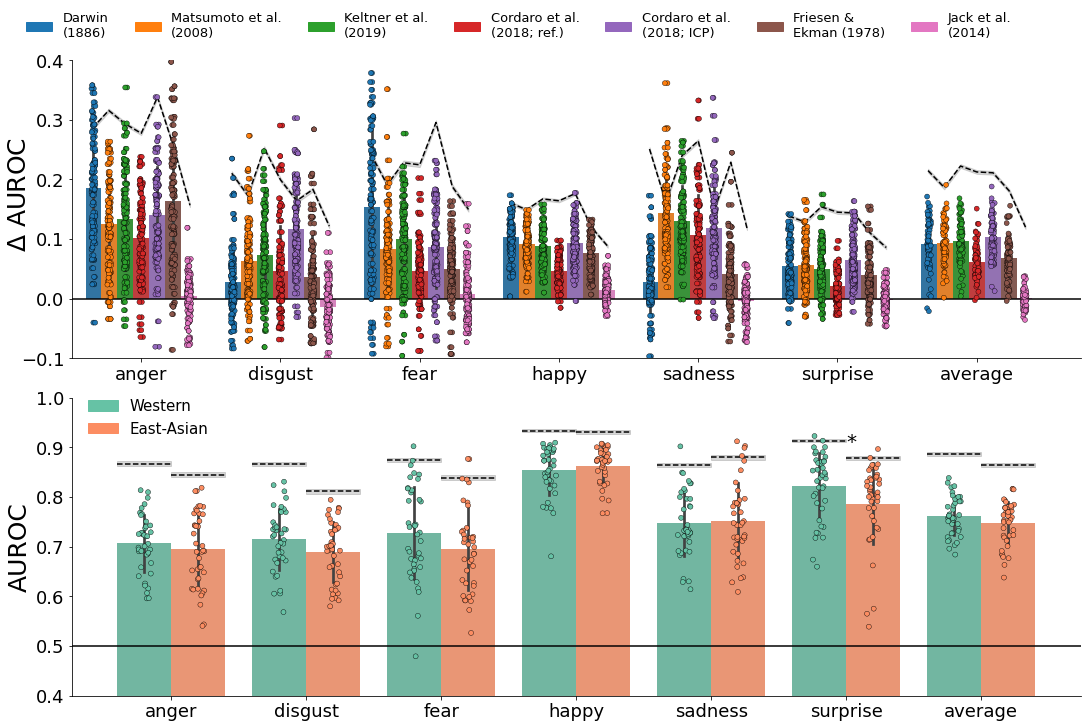

In [23]:
# NEW FIGURE
fig, axes = plt.subplots(figsize=(15, 10), constrained_layout=True, nrows=2)
ax1 = axes[0]
ax1 = sns.barplot(x='emotion', y='diff_score', data=df_o, hue='mapping',
                 ax=ax1, ci='sd')

ax1 = sns.stripplot(x='emotion', y='diff_score', hue='mapping', ax=ax1,
                    edgecolor='black', linewidth=0.4, data=df_o,
                    dodge=True, jitter=True)
            
ax1.set_ylabel(r'$\Delta$ AUROC', fontsize=25)
nc_ = nc.query("sub_ethnicity == 'all' & sub_split == 'test' & trial_split == 'test'")
for i, emo in enumerate(emo_names + ['average']):
    orig = df_o_av.query("emotion == @emo").set_index('mapping').loc[map_names, 'orig_score'].to_numpy()
    this_nc = nc_.query("emotion == @emo")['noise_ceiling'].item() - orig
    this_sd = nc_.query("emotion == @emo")['sd'].item()
    ax1.plot(np.linspace(i - 0.35, i + 0.35, num=7), this_nc, ls='--', c='k')
    ax1.fill_between(
        np.linspace(i-0.35, i+0.35, num=7),
        this_nc - this_sd, this_nc + this_sd,
        color='gray', alpha=0.3
    )

ax1.set_facecolor('white')
ax1.set_ylim(-0.1, 0.4)
ax1.axhline(0.5, c='k', ls='-')
ax1.legend_.remove()
colors = {mapp: sns.color_palette()[i] for i, mapp in enumerate(map_names)}
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
ax1.legend(handles, labels, ncol=7, loc=(-0.05, 1.05), frameon=False, fontsize=13)
ax1.yaxis.set_label_coords(-0.04, 0.55)

ax1.set_xlim(-0.5, 6.75)
ax1.set_xlabel('')
ax1.axhline(0, c='k')
ax1.tick_params(axis='y', labelsize=18)
ax1.tick_params(axis='x', labelsize=18)

ax2 = axes[1]
df_av_map = df_o.groupby(['emotion', 'sub_ethnicity', 'sub']).mean().reset_index()
hue_order = ['WC', 'EA']
ax2 = sns.barplot(x='emotion', y='opt_score', data=df_av_map, hue='sub_ethnicity', palette='Set2',
                 ax=ax2, ci='sd', hue_order=hue_order, order=emo_names + ['average'])

ax2 = sns.stripplot(x='emotion', y='opt_score', hue='sub_ethnicity', palette='Set2',
                   edgecolor='black', linewidth=0.4, data=df_av_map, ax=ax2,
                   dodge=True, jitter=True, hue_order=hue_order, order=emo_names + ['average'])

ax2.set_xlabel('')
ax2.set_ylabel('AUROC', fontsize=25, )
#ax2.yaxis.set_label_coords(-0.04, 0.55)

# Some aesthetics
ax2.set_facecolor('white')
ax2.set_ylim(0.4, 1.)
ax2.axhline(0.5, c='k', ls='-')

colors = {name: sns.color_palette('Set2')[i] for i, name in enumerate(['Western', 'East-Asian'])}
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
legend = ax2.legend(handles, labels, loc=(0.01, 0.85), frameon=False, fontsize=15)

ax2.tick_params(axis='y', labelsize=18)
ax2.tick_params(axis='x', labelsize=18)

for i, emo in enumerate(emo_names + ['average']):
    ea = df_av_map.query("emotion == @emo & sub_ethnicity == 'EA'")
    wc = df_av_map.query("emotion == @emo & sub_ethnicity == 'WC'")
    ea_ = ea['opt_score'].dropna().to_numpy()
    wc_ = wc['opt_score'].dropna().to_numpy()
    cohens_d = (wc_.mean() - ea_.mean()) / np.sqrt((wc_.var() + ea_.var()) / 2)
    tval, pval = ttest_ind(wc['opt_score'].dropna(), ea['opt_score'].dropna())
    print(f"Emotion = {emo}, t-value: {tval:.3f}, p-value: {pval:.5f}, d = {cohens_d:.2f}")    
    if pval < 0.05:
        ax2.text(i, 0.9, '*', fontsize=20)
        
for i, emo in enumerate(emo_names + ['average']):
    
    for ii, ethn in enumerate(['WC', 'EA']):
        nc_ = nc.query("sub_split == 'test' & trial_split == 'test' & sub_ethnicity == @ethn & emotion == @emo")
        this_nc = nc_['noise_ceiling'].item()
        this_sd = nc_['sd'].item()
        ax2.plot(np.linspace(i-0.4 + ii * 0.4, i + ii * 0.4, num=7), [this_nc] * 7, c='k', ls='--')

        ax2.fill_between(
            np.linspace(i-0.4 + ii * 0.4, i + ii * 0.4, num=7),
            this_nc - this_sd, this_nc + this_sd,
            color='gray', alpha=0.3
        )

sns.despine()
fig.set_constrained_layout_pads(h_pad=0.2)
plt.savefig('figure_S11_exploration_train.png', dpi=400, facecolor='white')


# Supplementary materials/results/figures

In [18]:
df = pd.read_csv('../results/scores_order_effect.tsv', sep='\t', index_col=0)
df = df.replace(map2leg)

# Add average across emotions to df for plotting (rightmost panel)
df_av = df.groupby(['mapping', 'sub', 'trial_percentile']).mean().reset_index()
df = pd.concat([df, df_av.assign(emotion='average')], axis=0)
df_av_map = df.groupby(['emotion', 'trial_percentile', 'sub']).mean().reset_index()

anger, -0.361, 0.71880, -0.03488
disgust, -1.350, 0.18097, -0.06800
fear, 1.367, 0.17545, 0.09905
happy, 1.989, 0.05012, 0.17613
sadness, 1.719, 0.08955, 0.10598
surprise, -1.025, 0.30864, -0.05682
average, 1.366, 0.17597, 0.06192


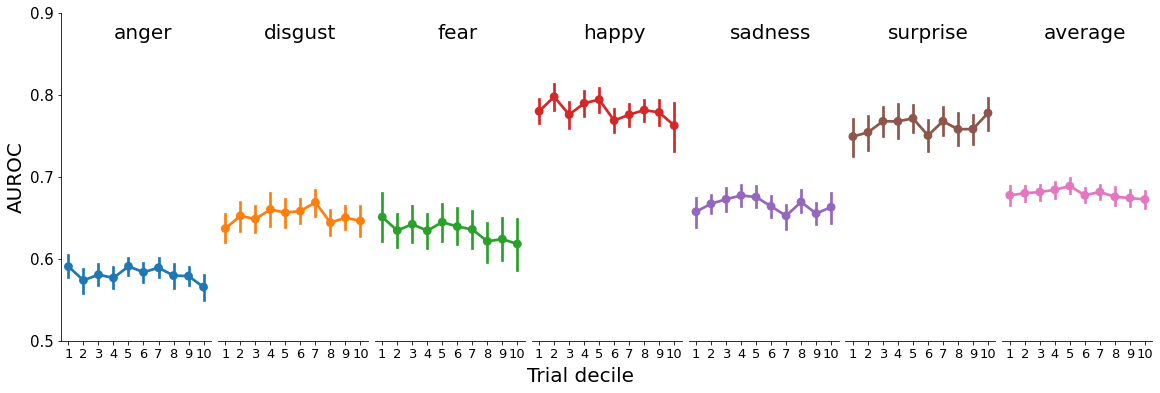

In [19]:
fig, ax2 = plt.subplots(figsize=(16, 5), constrained_layout=True, ncols=7, sharey=True, sharex=True)
for i, emo in enumerate(emo_names + ['average']):
    this_df = df_av_map.query("emotion == @emo")
    ax2[i] = sns.pointplot(x='trial_percentile', y='score',
                           linewidth=0.4, data=this_df, ax=ax2[i],
                           color=sns.color_palette()[i])
    
    if i != 0:
        ax2[i].get_yaxis().set_visible(False)
        ax2[i].spines['left'].set_visible(False)
        ax2[i].set_ylabel('')
    ax2[i].spines['top'].set_visible(False)
    ax2[i].spines['right'].set_visible(False)
    ax2[i].set_yticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
    ax2[i].set_yticklabels([0.4, 0.5, 0.6, 0.7, 0.8, 0.9], fontsize=15)
    ax2[i].set_xticklabels(range(1, 11), fontsize=13)
    ax2[i].set_xlabel('')
    ax2[i].text(5, 0.875, emo, ha='center', va='center', fontsize=20)
    
    first = this_df.query("trial_percentile < 50").groupby('sub').mean()['score'].to_numpy()
    last = this_df.query("trial_percentile >= 50").groupby('sub').mean()['score'].to_numpy()
    d = (first.mean() - last.mean()) / np.sqrt((first.var() + last.var()) / 2)
    tval, pval = ttest_rel(first, last)
    print(f'{emo}, {tval:.3f}, {pval:.5f}, {d:.5f}')
    
ax2[i].set_ylim(0.5, 0.9)
ax2[0].set_ylabel('AUROC', fontsize=20)
fig.text(0.5, -0.05, 'Trial decile', fontsize=20, ha='center')
fig.savefig('figure_S10_order_effect.png', dpi=400, bbox_inches='tight')

## Hyperparameters

In [ ]:
hp_df = pd.read_csv('../results/scores_hyperparameters.tsv', sep='\t', index_col=0)
BETA = 1

g = sns.catplot(x='emotion', y='score', data=hp_df.query("beta == @BETA"), hue='kernel', row='mapping',
                kind="bar", aspect=4, height=3, ci='sd')

g._legend.set_title('Kernel')
plt.setp(g._legend.get_title(), fontsize=16)
plt.setp(g._legend.get_texts(), fontsize=16)

for i, ax in enumerate(g.axes.flatten()):
    ax.text(-.3, 1, map_names[i], fontsize=20, verticalalignment='top')
    ax.set_title('')

    ax.set_ylim(0.4, 1.0)
    ax.axhline(0.5, ls='--', c='k')
    ax.set_ylabel("AUROC", fontsize=20)

g.set_xlabels('')
g.set_xticklabels(hp_df['emotion'].unique(), fontsize=20)

g._legend.set_bbox_to_anchor([1.12, 0.925])

plt.subplots_adjust(hspace=0.2)
fig = plt.gcf()
fig.tight_layout()
fig.savefig('figure_S7.png', dpi=400, bbox_inches='tight')

## Bias simulations (Supplementary Figure S4)

In [ ]:
df_naus = pd.read_csv('../results/scores_bias_simulation_n_aus.tsv', sep='\t', index_col=0)
df_naus = df_naus.groupby(['mapping', 'n_aus', 'emotion']).mean().reset_index()

df_nconf = pd.read_csv('../results/scores_bias_simulation_n_configs.tsv', sep='\t', index_col=0)
df_nconf = df_nconf.groupby(['mapping', 'n_configs', 'emotion']).mean().reset_index()

fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(12, 5))
sns.barplot(x='n_aus', y='score', data=df_naus, ci='sd', ax=axes[0])
sns.barplot(x='n_configs', y='score', data=df_nconf, ci='sd', ax=axes[1])
sns.despine()
axes[0].set_ylim(0.2, 0.8)
for ax in axes:
    ax.axhline(0.5, ls='--', c='k')

axes[0].set_ylabel('AUROC', fontsize=20)
axes[1].set_ylabel('')
axes[0].set_xlabel('Number of AUs per config', fontsize=20)
axes[1].set_xlabel('Number of configs per class', fontsize=20)

axes[0].text(-0.9, 0.85, 'A', fontsize=35)
axes[1].text(-0.9, 0.85, 'B', fontsize=35)

fig.tight_layout()
fig.savefig('figure_S8.png', dpi=400)

## Conversational models

In [13]:
df = pd.read_csv('../results/scores_conversational.tsv', sep='\t', index_col=0)

map2leg = {
    'Cunningham': 'Cunningham et al.\n(2005)',
    'Ekman': 'Ekman (1979)',
    'Forsyth': 'Forsyth et al.\n(1981)',
    'Kaliouby': 'Kaliouby & Robinson\n(2004)',
    'Craig': 'Craig et al.\n(2008)',
    #'Rozin': 'Rozin'
}
map_names = list(map2leg.values())
df = df.replace(map2leg)

-0.4
0.6
1.5999999999999999
2.6
-0.24
0.76
1.76
2.76
-0.08
0.92
1.92
2.92
0.07999999999999999
1.0799999999999998
2.08
3.08
0.24000000000000002
1.24
2.2399999999999998
3.2399999999999998


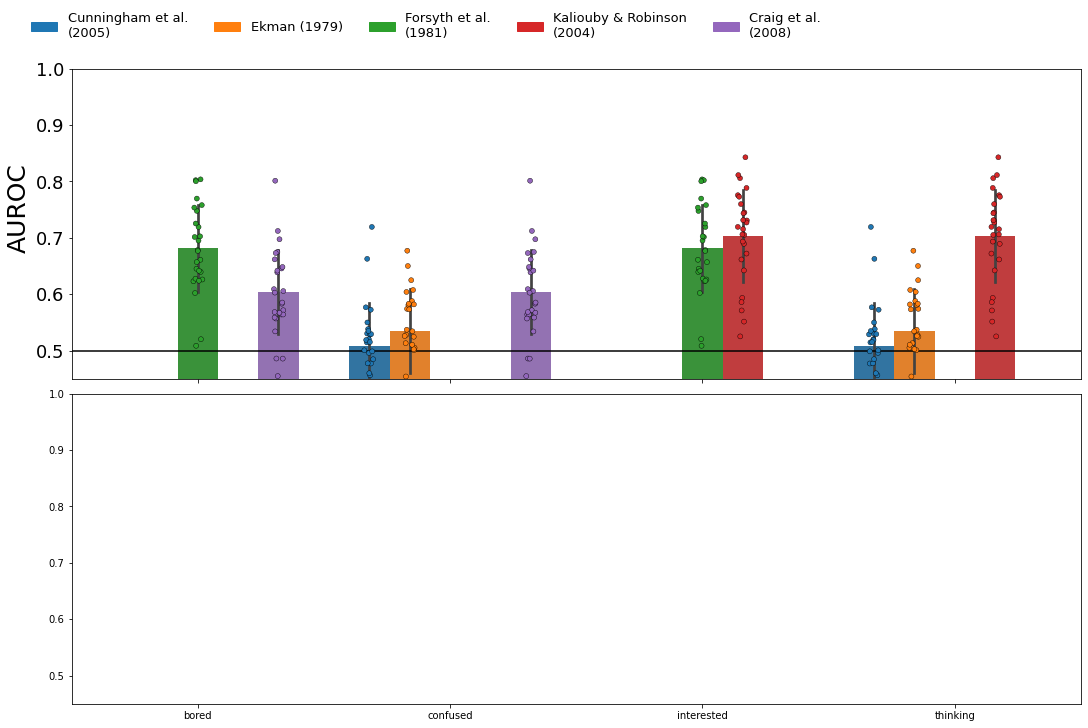

In [21]:
fig, axes = plt.subplots(figsize=(15, 10), nrows=2, ncols=constrained_layout=True, sharex=True, sharey=True)
ax = axes[0]
ax = sns.barplot(x='state', y='score', data=df, hue='mapping',
                 ax=ax, ci='sd', hue_order=map_names, order=['bored', 'confused', 'interested', 'thinking'])

for i, bar in enumerate(ax.axes.patches): 
    # move the missing to the centre
    current_width = bar.get_width()
    current_pos = bar.get_x()
    print(current_pos)
    # if i % 2 == 0:
    #     bar.set_x(i-(current_width/2))
    # else:
    #     bar.set_x(i+(current_width/2))
    # # move also the std mark
    # ax.axes.lines[i].set_xdata(i)

ax = sns.stripplot(x='state', y='score', hue='mapping',
                   edgecolor='black', linewidth=0.4, data=df, ax=ax,
                   dodge=True, jitter=True, hue_order=map_names, order=['bored', 'confused', 'interested', 'thinking'])

ax.set_xlabel('')
ax.set_ylabel('AUROC', fontsize=25, )
ax.yaxis.set_label_coords(-0.04, 0.55)

n_tk = df['mapping'].unique().size

# Some aesthetics
ax.set_facecolor('white')
ax.set_ylim(0.45, 1)
ax.axhline(0.5, c='k', ls='-')
ax.legend_.remove()
colors = {mapp: sns.color_palette()[i] for i, mapp in enumerate(map_names)}
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
legend = ax.legend(handles, labels, ncol=7, loc=(-0.045, 1.075), frameon=False, fontsize=13)

ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=18)

# ax = axes[1]
# df_av_map = df.groupby(['state', 'sub_ethnicity', 'sub']).mean().reset_index()
# hue_order = ['WC', 'EA']
# ax = sns.barplot(x='state', y='score', data=df_av_map, hue='sub_ethnicity', palette='Set2',
#                  ax=ax, ci='sd', hue_order=hue_order, order=['bored', 'confused', 'interested', 'thinking'])

# ax = sns.stripplot(x='state', y='score', hue='sub_ethnicity', palette='Set2',
#                    edgecolor='black', linewidth=0.4, data=df_av_map,
#                    dodge=True, jitter=True, hue_order=hue_order, order=['bored', 'confused', 'interested', 'thinking'])

# ax.set_xlabel('')
# ax.set_ylabel('AUROC', fontsize=25, )
# ax.yaxis.set_label_coords(-0.04, 0.55)

# # Some aesthetics
# ax.set_facecolor('white')
# ax.set_ylim(0.45, 1)
# ax.axhline(0.5, c='k', ls='-')

# colors = {name: sns.color_palette('Set2')[i] for i, name in enumerate(['Western', 'East-Asian'])}
# labels = list(colors.keys())
# handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
# legend = plt.legend(handles, labels, loc=(0.01, 0.82), frameon=False, fontsize=15)

# ax.tick_params(axis='y', labelsize=18)
# ax.tick_params(axis='x', labelsize=18)

# for i, state in enumerate(['confused', 'interested', 'bored', 'thinking']):
#     ea = df.query("state == @state & sub_ethnicity == 'EA'")
#     wc = df.query("state == @state & sub_ethnicity == 'WC'")
    
#     # Average across mappings
#     wc = wc.groupby(['state', 'sub', 'sub_ethnicity']).mean().reset_index()
#     ea = ea.groupby(['state', 'sub', 'sub_ethnicity']).mean().reset_index()
    
#     wc_, ea_ = wc['score'].dropna().to_numpy(), ea['score'].dropna().to_numpy()
#     cohens_d = (wc_.mean() - ea_.mean()) / np.sqrt((wc_.var() + ea_.var()) / 2)
#     tval, pval = ttest_ind(wc_, ea_)
#     print(f"Emotion = {state}, t-value: {tval:.2f}, p-value: {pval:.5f}, d: {cohens_d:.2f}")    
#     if pval < 0.05:
#         ax.text(i, 0.95, '*', fontsize=20)

# sns.despine()
# fig.set_constrained_layout_pads(h_pad=0.25)
# #plt.savefig('figure_3.png', dpi=100, facecolor='white', bbox_inches='tight')


## Exploration

In [9]:
df_o = pd.read_csv('../results/scores_optimal_conversational.tsv', sep='\t', index_col=0)
# Extract culture-accented model results
df_o = df_o.query("(model_ethnicity == 'EA' & sub_ethnicity == 'EA') | (model_ethnicity == 'WC' & sub_ethnicity == 'WC')")
df_o = df_o.replace(map2leg)
df_o_av = df_o.groupby(['mapping', 'state']).mean().reset_index()

Emotion = confused, t-value: 2.422, p-value: 0.03218
Emotion = interested, t-value: -1.209, p-value: 0.24990
Emotion = bored, t-value: 0.584, p-value: 0.56976
Emotion = thinking, t-value: 0.986, p-value: 0.34341


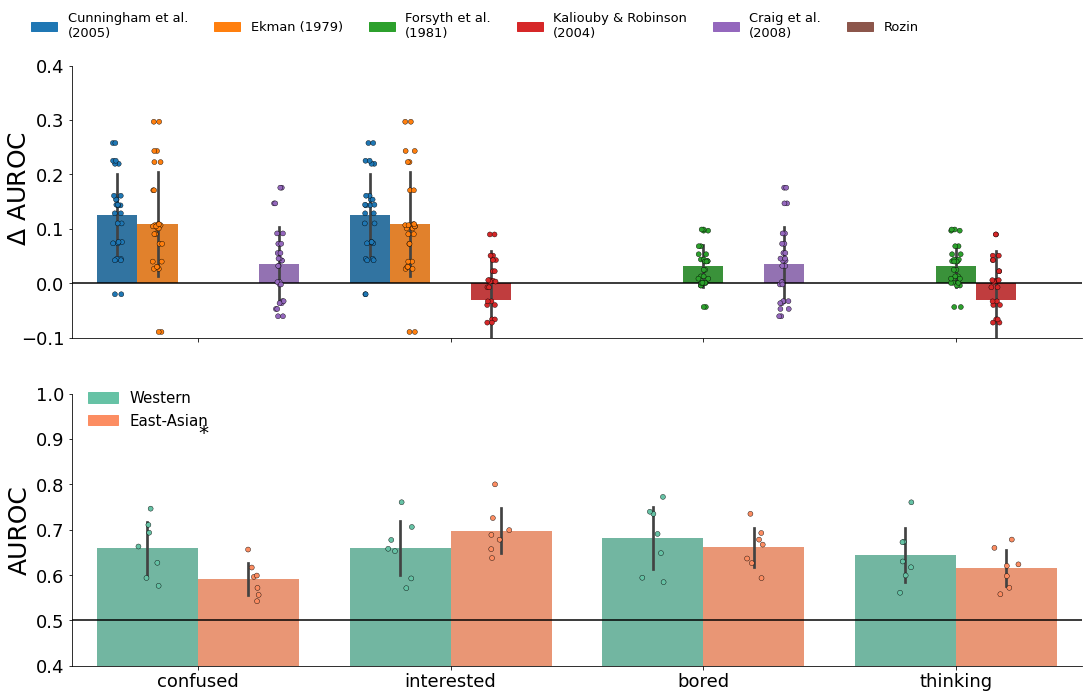

In [10]:
# NEW FIGURE
fig, axes = plt.subplots(figsize=(15, 10), constrained_layout=True, nrows=2, sharex=True)
ax1 = axes[0]
ax1 = sns.barplot(x='state', y='diff_score', data=df_o, hue='mapping',
                 ax=ax1, ci='sd')

ax1 = sns.stripplot(x='state', y='diff_score', hue='mapping', ax=ax1,
                    edgecolor='black', linewidth=0.4, data=df_o,
                    dodge=True, jitter=True)
            
ax1.set_ylabel(r'$\Delta$ AUROC', fontsize=25)

ax1.set_facecolor('white')
ax1.set_ylim(-0.1, 0.4)
ax1.axhline(0.5, c='k', ls='-')
ax1.legend_.remove()
colors = {mapp: sns.color_palette()[i] for i, mapp in enumerate(map_names)}
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
ax1.legend(handles, labels, ncol=7, loc=(-0.045, 1.075), frameon=False, fontsize=13)
ax1.yaxis.set_label_coords(-0.04, 0.55)

ax1.set_xlim(-0.5, 6.75)
ax1.set_xlabel('')
ax1.axhline(0, c='k')
ax1.tick_params(axis='y', labelsize=18)
ax1.tick_params(axis='x', labelsize=18)

ax2 = axes[1]
df_av_map = df_o.groupby(['state', 'sub_ethnicity', 'sub']).mean().reset_index()
hue_order = ['WC', 'EA']
ax2 = sns.barplot(x='state', y='opt_score', data=df_av_map, hue='sub_ethnicity', palette='Set2',
                 ax=ax2, ci='sd', hue_order=hue_order, order=['confused', 'interested', 'bored', 'thinking'])

ax2 = sns.stripplot(x='state', y='opt_score', hue='sub_ethnicity', palette='Set2',
                   edgecolor='black', linewidth=0.4, data=df_av_map, ax=ax2,
                   dodge=True, jitter=True, hue_order=hue_order, order=['confused', 'interested', 'bored', 'thinking'])

ax2.set_xlabel('')
ax2.set_ylabel('AUROC', fontsize=25, )
#ax2.yaxis.set_label_coords(-0.04, 0.55)

# Some aesthetics
ax2.set_facecolor('white')
ax2.set_ylim(0.4, 1.)
ax2.axhline(0.5, c='k', ls='-')

colors = {name: sns.color_palette('Set2')[i] for i, name in enumerate(['Western', 'East-Asian'])}
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
legend = ax2.legend(handles, labels, loc=(0.01, 0.85), frameon=False, fontsize=15)

ax2.tick_params(axis='y', labelsize=18)
ax2.tick_params(axis='x', labelsize=18)

for i, state in enumerate(['confused', 'interested', 'bored', 'thinking']):
    ea = df_av_map.query("state == @state & sub_ethnicity == 'EA'")
    wc = df_av_map.query("state == @state & sub_ethnicity == 'WC'")
    tval, pval = ttest_ind(wc['opt_score'].dropna(), ea['opt_score'].dropna())
    print(f"Emotion = {state}, t-value: {tval:.3f}, p-value: {pval:.5f}")    
    if pval < 0.05:
        ax2.text(i, 0.9, '*', fontsize=20)

sns.despine()
fig.set_constrained_layout_pads(h_pad=0.25)
#plt.savefig('figure_5.png', dpi=100, facecolor='white', bbox_inches='tight')
